In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    else:
        return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    else:
        return 0.5 * np.mean((y - y_pred) ** 2)

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y * np.log(y_sigmoid) + (1 - y) * np.log(1 - y_sigmoid))

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

In [7]:
#não utilizar metodos de inicializar com apenas zeros e uns para não ter uma rede simetrica
def zeros(rows, columns):
    return np.zeros((rows, columns))

def ones(rows, columns):
    return np.ones((rows, columns))

#normal aleatoria
def random_normal(rows, columns):
    return np.random.randn(rows, columns)

#uniforme aletaria
def random_uniform(rows, columns):
    return np.random.rand(rows, columns)

#glorot uniforme quebra a simetria e converge mais rapidamente sqrt(6/(in + out))
def glorot_uniform(rows, columns):
    limit = np.sqrt(6/(rows + columns))
    return 2*limit * np.random.rand(rows, columns) - limit

#glorot normal quebra a simetria e converge mais rapidamente sqrt(2/(in + out))
def glorot_normal(rows, columns):
    std_dev = np.sqrt(2/(rows + columns))
    return std_dev * np.random.randn(rows, columns)

In [8]:
#regularização L1 mata alguns neoronios, faz seleção de atributos importantes, dificil de estimar aplique apenas em casos de overfitting 
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

#regularização L2 nenhum atributo é mais importante, tende a diminui e espelaha valores e decaimento dos pesos, dificil de estimar aplique apenas em overfitting
def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

In [9]:
#Mini-batch divide o conjunto de treinamento em conjuntos menores, é importante dar shuffle (embaralhar) antes de cada epoch = processar todos os batch em geral é 
# a estratégia de gradiente descendente mais utilizada
#gradiente estocastico aprende com apenass uma amostra por vez, gradiente para cada amostra, conversão lenta, anula vetorização
#mini-batch Em geral aponta para direção que desce, converge rapido, mas não tão rapido como batch, rapida execução
#batch gradiente aponta para direção que sempre desce, converge rapido, execução lenta

def batch_sequential(x, y, batch_size = None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batchs = x.shape[0] // batch_size
    for batch in range(n_batchs):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield(x_batch,y_batch)

def batch_shuffle(x, y, batch_size = None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

In [10]:
#learning rate influencia diretamente a aprendizagem da rede, valores altos e baixos, busca decair a learning rate ao longo do tempo
#time based menor o alpha menor a aprendizagem
def none_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return learnin_rate

def time_based_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return 1 / (1 + decay_rate * epoch)

#exponencial maior o alpha menor aprendizagem
def exponential_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return learnin_rate * decay_rate ** epoch

#stair case decaimento controlado por epochs
def staircase_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return learnin_rate * decay_rate ** (epoch // decay_steps)

In [11]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1. / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0, reg_func=l2_regularization, reg_strength=0, batch_norm = False, bn_decay =0.9, is_trainable = True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1,output_dim), zeros(1,output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method = none_decay, lr_decay_rate = 0, lr_decay_steps = 1,momentum=0, patience = np.inf):
        self.layers = []
        self.cost_function = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf

    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)

        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feed_forward(x_batch)
                self.__back_propagation(y_batch, y_pred)

            loss_val = self.cost_function(y_val, self.predict(x_val))
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_function(y_train, self.predict(x_train))
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, loss_train, loss_reg, loss_train + loss_reg, loss_val))

    def predict(self, x):
        return self.__feed_forward(x,is_training = False)
    
    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)

    def load(file_path):
        return pkl.load(open(file_path, 'rb'))

    def __feed_forward(self, x, is_training = True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1 - current_layer.dropout_prob, y.shape) / (1 - current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __back_propagation(self, y, y_pred):
        last_delta = self.cost_function(y, y_pred, derivative = True)
        for layer in reversed(self.layers):
            d_activation = layer.activation(layer._activ_inp, derivative = True) * last_delta * layer._dropout_mask
            d_activation = batchnorm_backward(layer, d_activation) if layer.batch_norm else d_activation
            last_delta = np.dot(d_activation, layer.weights)
            layer._dweights = np.dot(d_activation.T, layer.input)
            layer._dbiases = 1.0 * d_activation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate * layer._dweights + self.momentum * layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate * layer._dbiases
                
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                    layer.beta = layer.beta - self.learning_rate * layer._dbeta

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


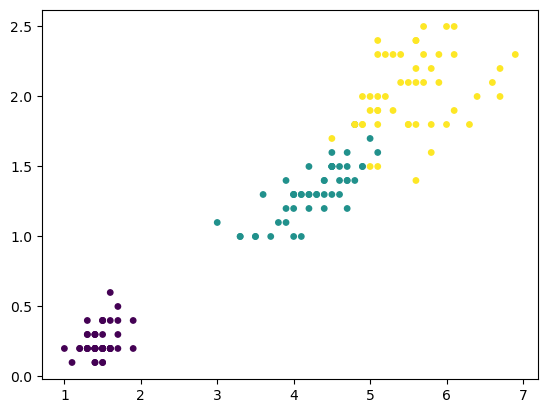

In [13]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=1)

In [15]:
onehot = OneHotEncoder(sparse_output=False)
y_train_onehot = onehot.fit_transform(y_train)
y_test_onehot = onehot.fit_transform(y_test)

print(y_train_onehot[::20])
print(y_test_onehot[::20])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [16]:
input_dim, output_dim = x_train.shape[1], y_train_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(softmax_neg_log_likelihood, 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=25, activation=tanh))
nn.layers.append(Layer(input_dim=25, output_dim=20, activation=leaky_relu))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x_train, y_train_onehot, epochs = 100000, verbose = 10000, batch_gen=batch_shuffle, batch_size=15)

epoch:    0/100000 loss_train: 1.09041896 + 0.00000000 = 1.09041896 loss_val = 1.09041896
epoch: 10000/100000 loss_train: 0.05488485 + 0.00000000 = 0.05488485 loss_val = 0.05488485
epoch: 20000/100000 loss_train: 0.04300669 + 0.00000000 = 0.04300669 loss_val = 0.04300669
epoch: 30000/100000 loss_train: 0.04136648 + 0.00000000 = 0.04136648 loss_val = 0.04136648
epoch: 40000/100000 loss_train: 0.04028546 + 0.00000000 = 0.04028546 loss_val = 0.04028546
epoch: 50000/100000 loss_train: 0.03930726 + 0.00000000 = 0.03930726 loss_val = 0.03930726
epoch: 60000/100000 loss_train: 0.03876633 + 0.00000000 = 0.03876633 loss_val = 0.03876633
epoch: 70000/100000 loss_train: 0.03792968 + 0.00000000 = 0.03792968 loss_val = 0.03792968
epoch: 80000/100000 loss_train: 0.03752750 + 0.00000000 = 0.03752750 loss_val = 0.03752750
epoch: 90000/100000 loss_train: 0.03699461 + 0.00000000 = 0.03699461 loss_val = 0.03699461
epoch: 100000/100000 loss_train: 0.03663756 + 0.00000000 = 0.03663756 loss_val = 0.03663756

In [17]:
# Lista de resultados
results = []

# Iterar pelos hiperparâmetros
for criterion in ['gini', 'entropy']:
    for max_depth in [None, 10, 20, 30, 40, 50]:
        for min_samples_split in [2, 5, 10]:
            for min_samples_leaf in [1, 2, 4]:
                for max_features in [None, 'sqrt', 'log2']:
                    
                    # Criar e treinar o modelo
                    model_decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                                                                  max_features=max_features)
                    model_decision_tree.fit(x_train, y_train)

                    # Avaliar o modelo
                    accuracy = model_decision_tree.score(x_test, y_test)
                    
                    # Salvar os resultados
                    results.append({
                        'criterion': criterion,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'max_features': max_features,
                        'accuracy': accuracy
                    })

# Criar DataFrame dos resultados
results_df = pd.DataFrame(results)

# Exibir os melhores resultados
best_results = results_df.loc[results_df['accuracy'].idxmax()]
print("Melhores parâmetros encontrados:")
print(best_results)

Melhores parâmetros encontrados:
criterion                gini
max_depth                 NaN
min_samples_split           2
min_samples_leaf            2
max_features             log2
accuracy             0.977778
Name: 5, dtype: object


In [18]:
model_decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=5, min_samples_leaf=1, max_features='sqrt')
model_decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_features='sqrt', min_samples_split=5)

In [19]:
prevision_dicision_tree = model_decision_tree.predict(x_test)
y_pred = np.argmax(nn.predict(x_test), axis=1)

print(f'Acurácia da arvore de decisao: {(accuracy_score(y_test, prevision_dicision_tree) * 100):.2f}%')
print('Acurácia da rede neural: {:.2f}%'.format(100*accuracy_score(y_test, y_pred)))

Acurácia da arvore de decisao: 95.56%
Acurácia da rede neural: 95.56%
